In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy 
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord

import sys
sys.path.extend(['/Users/lynnej/other_repos/'])

In [2]:
from tvs_software_tools import generate_gp_maps

## Set up sky grid and information ##

In [3]:
import numpy.ma as ma
from rubin_sim import data as rs_data
import rubin_sim.utils as rs_utils
import rubin_sim.maf as maf

class SurveyMap:
    def __init__(self, nside=64, default_filter_balance=None):
        self.nside = nside
        # We use this for making pretty plots if desired.
        self.slicer = maf.HealpixSlicer(nside)
        # healpix indexes
        self.hpid = np.arange(0, hp.nside2npix(nside))
        # Ra/dec in degrees and other coordinates
        self.ra, self.dec = hp.pix2ang(nside, self.hpid, lonlat=True)
        self.coord = SkyCoord(ra=self.ra * u.deg, dec=self.dec * u.deg, frame='icrs')
        self.eclip_lat = self.coord.barycentrictrueecliptic.lat.deg
        self.eclip_lon = self.coord.barycentrictrueecliptic.lon.deg
        self.gal_lon = self.coord.galactic.l.deg
        self.gal_lat = self.coord.galactic.b.deg
        # filterlist
        self.filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
        # SRD values
        self.nvis_min_srd = 750
        self.nvis_goal_srd = 825
        self.area_min_srd = 15000
        self.area_goal_srd = 18000
        if default_filter_balance is None:
            self.default_filter_balance = {'u': 0.07, 'g': 0.09, 'r': 0.22, 
                                           'i': 0.22, 'z': 0.20, 'y': 0.20}
        else:
            self.default_filter_balance = self._normalize_filter_balance(default_filter_balance)
        # These maps store the per-region information, on scales from 0-1
        self.maps = {}
        self.maps_perfilter = {}
        # The nvis values store the max per-region number of visits, so regions can be added together
        self.nvis = {}
        # Set a default self.dec_max = 12 deg here, but will be re-set/overriden when setting low-dust wfd
        self.dec_max = 12
    
    def read_dustmap(self, dustmapFile=None):
        # Dustmap from rubin_sim_data  - this is basically just a data directory
        # The dustmap data is downloadable from 
        # https://lsst.ncsa.illinois.edu/sim-data/rubin_sim_data/maps_may_2021.tgz
        # (then just set RUBIN_SIM_DATA_DIR to where you downloaded it, after untarring the file)
        if dustmapFile is None:
            datadir = rs_data.get_data_dir()
            if datadir is None:
                raise Exception('Cannot find datadir, please set "RUBIN_SIM_DATA_DIR"')
            datadir = os.path.join(datadir, 'maps', 'DustMaps')
            filename = os.path.join(datadir, 'dust_nside_%i.npz' % nside)
        self.dustmap = np.load(filename)['ebvMap']
        
    def _normalize_filter_balance(self, filter_balance):
        filtersum = np.array(list(filter_balance.values())).sum()
        tmp = {k: round(v/filtersum, 2) for k, v in filter_balance.items()}
        for f in self.filterlist:
            if f not in tmp:
                tmp[f] = 0
        return tmp
    
    # The various regions take the approach that they should be independent
    # And after setting all of the regions, we take the max value (per filter?) in each part of the sky
    # The individual components are updated, so that we can still calculate survey fraction per part of the sky
    
    def _set_dustfree_wfd(self, dust_limit=0.199, dec_min=-65, dec_max=12, 
                          smoothing_cutoff=0.45, smoothing_beam=10, 
                          nvis_dustfree_wfd=825*1.08,
                          dustfree_wfd_filter_balance=None, 
                          adjust_halves=True):
        # Define low dust extinction WFD between dec_min and dec_max (ish) with low dust extinction 
        # These dec and dust limits are used to define the other survey areas as well.
        # We're also going to weight the footprint differently in the region around RA=0 
        # compared to the region around RA=180, as the RA=0 half is more heavily subscribed (if adjust_halves True)
        self.dust_limit = dust_limit
        self.dec_min = dec_min
        self.dec_max = dec_max
        if dustfree_wfd_filter_balance is None:
            self.dustfree_wfd_filter_balance = self.default_filter_balance
        else:
            self.dustfree_wfd_filter_balance = self._normalize_filter_balance(dustfree_wfd_filter_balance)
        
        # Set the detailed dust boundary 
        self.dustfree = np.where((self.dec > self.dec_min) & (self.dec < self.dec_max) 
                                   & (self.dustmap < self.dust_limit), 1, 0)
        # Set the smoothed dust boundary using the original dustmap and smoothing it with gaussian PSF
        self.maps['dustfree'] = np.where((self.dustmap < self.dust_limit), 1, 0)
        self.maps['dustfree'] = hp.smoothing(self.maps['dustfree'], fwhm=np.radians(smoothing_beam))
        self.maps['dustfree'] = np.where((self.dec > self.dec_min) & (self.dec < self.dec_max)
                                     & (self.maps['dustfree']>smoothing_cutoff), 1, 0)
        
        # Reset to downweight RA=0 and upweight RA=180 side by 
        # reducing upper dec limit in one half, increasing lower dec limit in other half
        if adjust_halves:
            self.maps['dustfree'] = np.where((self.gal_lat < 0) & (self.dec > dec_max - 7), 
                                      0, self.maps['dustfree'])
            # The lower dec limit doesn't really apply for the other 'half' of the low-dust WFD 
            # as the dust-extinction cuts off the footprint in that area at about Dec=-50
            # This is another reason that the dust-free region is oversubscribed.

        # Make per-filter maps for the footprint
        self.maps_perfilter['dustfree'] = {}
        for f in self.filterlist:
            self.maps_perfilter['dustfree'][f] = self.maps['dustfree'] * self.dustfree_wfd_filter_balance[f]
        self.nvis['dustfree'] = nvis_dustfree_wfd
        
    def _set_circular_region(self, ra_center, dec_center, radius):
        # find the healpixels that cover a circle of radius radius around ra/dec center (deg)
        result = np.zeros(len(self.ra))
        distance = rs_utils._angularSeparation(np.radians(ra_center), np.radians(dec_center),
                                               np.radians(self.ra), np.radians(self.dec))
        result[np.where(distance < np.radians(radius))] = 1
        return result
        
    def _set_magellanic_clouds(self, lmc_radius=8, smc_radius=5, 
                              nvis_mcs = 825,
                              mcs_filter_balance=None):
        # Define the magellanic clouds region
        if mcs_filter_balance is None:
            self.mcs_filter_balance = self.default_filter_balance
        else:
            self.mcs_filter_balance = self._normalize_filter_balance(mc_filter_balance)

        self.maps['mcs'] = np.zeros(hp.nside2npix(nside))
        # Define the LMC center and size
        self.lmc_ra = 80.893860
        self.lmc_dec = -69.756126
        self.lmc_radius = lmc_radius
        # Define the SMC center and size
        self.smc_ra = 13.186588
        self.smc_dec = -72.828599
        self.smc_radius = smc_radius
        # Define the LMC pixels
        self.maps['mcs'] += self._set_circular_region(self.lmc_ra, self.lmc_dec, self.lmc_radius)
        # Define the SMC pixels
        self.maps['mcs'] += self._set_circular_region(self.smc_ra, self.smc_dec, self.smc_radius)
        # We don't want to double-visit areas which may overlap
        self.maps['mcs'] = np.where(self.maps['mcs'] > 1, 1, self.maps['mcs'])

        # Make per-filter maps for the footprint
        self.maps_perfilter['mcs'] = {}
        for f in self.filterlist:
            self.maps_perfilter['mcs'][f] = self.maps['mcs'] * self.mcs_filter_balance[f]
        self.nvis['mcs'] = nvis_mcs
    
    def __set_bulge_diamond(self, center_width, end_width, gal_long1, gal_long2):
        """
        Define a Galactic Bulge diamond-ish region.

        Parameters
        ----------
        center_width : float
            Width at the center of the galactic plane region.
        end_width : float
            Width at the remainder of the galactic plane region.
        gal_long1 : float
            Longitude at which to start the GP region.
        gal_long2 : float
            Longitude at which to stop the GP region.
            Order matters for gal_long1 / gal_long2!
        Returns
        -------
        np.ndarray
        """
        # Reject anything beyond the central width.
        bulge = np.where(np.abs(self.gal_lat) < center_width, 1, 0)
        # Apply the galactic longitude cuts, so that plane goes between gal_long1 to gal_long2.
        # This is NOT the shortest distance between the angles.
        gp_length = (gal_long2 - gal_long1) % 360
        # If the length is greater than 0 then we can add additional cuts.
        if gp_length > 0:
            # First, remove anything outside the gal_long1/gal_long2 region.
            bulge = np.where(((self.gal_lon - gal_long1) % 360) < gp_length, bulge, 0)
            # Add the tapers.
            # These slope from the center (gp_center @ center_width)
            # to the edges (gp_center + gp_length/2 @ end_width).
            half_width = gp_length / 2.
            slope = (center_width - end_width) / half_width
            # The 'center' can have a wrap-around 0 problem
            gp_center = (gal_long1 + half_width) % 360
            # Calculate the longitude-distance between any point and the 'center'
            gp_dist = (self.gal_lon - gp_center) % 360
            gp_dist = np.abs(np.where((gp_dist > 180), (180 - gp_dist) % 180, gp_dist))
            lat_limit = np.abs(center_width - slope * gp_dist)
            bulge = np.where((np.abs(self.gal_lat)) < lat_limit, bulge, 0)
        return bulge
    
    def _set_galactic_plane(self, dec_max=12,
                            center_width_A=11, end_width_A=4, gal_long1_A=330, gal_long2_A=30, 
                           center_width_B=15, end_width_B=5, gal_long1_B=250, gal_long2_B=100,
                           gal_lat_width_max=23,
                           nvis_gal_A=825, nvis_gal_B=300, nvis_gal_min=250, gal_filter_balance=None):
        if gal_filter_balance is None:
            self.gal_filter_balance = {'u': 0.04, 'g': 0.22, 'r': 0.24,
                                      'i': 0.24, 'z': 0.22, 'y': 0.05}
        else:
            self.gal_filter_balance = self._normalize_filter_balance(gal_filter_balance)
        self.gal_dec_max = dec_max

        # Set up central bulge
        self.bulge_A = self.__set_bulge_diamond(center_width=center_width_A, end_width=end_width_A,
                                               gal_long1=gal_long1_A, gal_long2=gal_long2_A)
        self.bulge_A = np.where(self.dec > self.gal_dec_max, 0, self.bulge_A)
        # And a secondary bulge-ish region to follow further stars
        self.bulge_B = self.__set_bulge_diamond(center_width=center_width_B, end_width=end_width_B,
                                               gal_long1=gal_long1_B, gal_long2=gal_long2_B)
        self.bulge_B = np.where(self.dec > self.gal_dec_max, 0, self.bulge_B)
        # Remove regions of these bulges which go further north than dec_max
        # Set up 'background' galactic plane visits 
        self.gp_bkgnd = np.where((np.abs(self.gal_lat) < gal_lat_width_max) & (self.dec < self.dec_max), 1, 0)
        # Remove the areas that overlap
        self.bulge_B = self.bulge_B - self.bulge_A
        self.gp_bkgnd = self.gp_bkgnd - self.bulge_A - self.bulge_B
        
        # Add them together
        self.maps['gal'] = (self.gp_bkgnd * nvis_gal_min / nvis_gal_A 
                   + self.bulge_B * nvis_gal_B / nvis_gal_A
                   + self.bulge_A)
        
        # Make per-filter maps for the footprint
        self.maps_perfilter['gal'] = {}
        for f in self.filterlist:
            self.maps_perfilter['gal'][f] = self.maps['gal'] * self.gal_filter_balance[f]
        self.nvis['gal'] = nvis_gal_A
            
    def _set_nes(self, eclat_min=-10, eclat_max=10, eclip_dec_min=-10, eclip_ra_max=180, 
                 nvis_nes=400, nes_filter_balance=None):
        if nes_filter_balance is None:
            self.nes_filter_balance =  {'u': 0.0, 'g': 0.2, 'r': 0.3, 'i': 0.3, 'z': 0.2, 'y': 0.0}
        else:
            self.nes_filter_balance = self._normalize_filter_balance(nes_filter_balance)
        # NES ecliptic latitude values tend to be assymetric because NES goes so far north
        self.eclat_min = eclat_min
        self.eclat_max = eclat_max
        self.eclip_dec_min = eclip_dec_min
        self.eclip_ra_max = eclip_ra_max

        self.maps['nes'] = np.where(((self.eclip_lat > self.eclat_min) | 
                                 ((self.dec > self.eclip_dec_min) & (self.ra < self.eclip_ra_max)))
                                 & (self.eclip_lat < self.eclat_max), 1, 0)
        self.maps_perfilter['nes'] = {}
        for f in self.filterlist:
            self.maps_perfilter['nes'][f] = self.maps['nes'] * self.nes_filter_balance[f]
        self.nvis['nes'] = nvis_nes
            
    def _set_scp(self, nvis_scp=120, dec_max=12, scp_filter_balance=None):
        if scp_filter_balance is None:
            self.scp_filter_balance = {'u': 0.17, 'g': 0.17, 'r': 0.17, 'i': 0.17, 'z': 0.17, 'y': 0.17}
        else:
            self.scp_filter_balance = self._normalize_filter_balance(scp_filter_balance)
        # Basically this is a fill-in so that we don't have any gaps below the max dec limit for the survey
        # I would expect most of this to be ignored
        self.maps['scp'] = np.where(self.dec < dec_max, 1, 0)
        self.maps_perfilter['scp'] = {}
        for f in self.filterlist:
            self.maps_perfilter['scp'][f] = self.maps['scp'] * self.scp_filter_balance[f]
        self.nvis['scp'] = nvis_scp
        
    def _set_ddf(self, nvis_ddf=18000, ddf_radius=1.8, ddf_filter_balance=None):
        # These should not be set up for most footprint work with the scheduler, but are helpful
        # for evaluating RA over or under subscription
        if ddf_filter_balance is None:
            # This is an estimate based on existing simulations
            self.ddf_filter_balance = {'u': 0.06, 'g': 0.12, 'r': 0.23, 'i': 0.23, 'z': 0.13, 'y': 0.23}
        else: 
            self.ddf_filter_balance = self._normalize_filter_balance(ddf_filter_balance)
        self.ddf_radius = ddf_radius
        self.ddf_centers = rs_utils.ddf_locations()
        self.maps['ddf'] = np.zeros(len(self.hpid))
        for dd in self.ddf_centers:
            self.maps['ddf'] += self._set_circular_region(self.ddf_centers[dd][0], 
                                                          self.ddf_centers[dd][1], 
                                                          self.ddf_radius)
        self.maps['ddf'] = np.where(self.maps['ddf'] > 1, 1, self.maps['ddf'])
        
        self.maps_perfilter['ddf'] = {}
        for f in self.filterlist:
            self.maps_perfilter['ddf'][f] = self.maps['ddf'] * self.ddf_filter_balance[f]
        self.nvis['ddf'] = nvis_ddf
    
    def set_maps(self, dustfree=True, mcs=True, gp=True, nes=True, scp=True, ddf=False):
        # This sets each component with default values.
        # Individual components could be set with non-default values by calling those methods - 
        #  in general they are independent (just combined at the end).
        # Each component has a 'map' (with values from 0-1) for the total visits in all filters
        # and then a maps_per_filter (with values from 0-1) for the fraction of those visits
        # which will happen in each filter. Each component also has a 'nvis' value (nvis at the map max value),
        # which serves to weight each map to their final combined value in the footprint.
        self.read_dustmap()
        if dustfree:
            self._set_dustfree_wfd()
        if mcs:
            self._set_magellanic_clouds()
        if gp:
            self._set_galactic_plane()
        if nes:
            self._set_nes()
        if scp:
            self._set_scp()
        if ddf:
            self._set_ddf()
    
    def combine_maps(self):
        self.total_perfilter = {}
        for f in self.filterlist:
            self.total_perfilter[f] = np.zeros(len(self.hpid), float)
        for m in self.maps:
            if m == 'ddf':
                continue # skip DDF 
            for f in self.filterlist:
                self.total_perfilter[f] = np.maximum(self.total_perfilter[f], 
                                                     self.maps_perfilter[m][f] * self.nvis[m])
        if 'ddf' in self.maps:
            # Now add DDF on top of individual maps
            for f in self.filterlist:
                self.total_perfilter[f] += self.maps_perfilter['ddf'][f] * self.nvis['ddf']
                
        # Generate the total footprint using the combination of the per-filter values
        self.total = np.zeros(len(self.hpid), float)
        for f in self.filterlist:
            self.total += self.total_perfilter[f]

    def normalize_for_sched(self):
        footprint_r = {}
        new_nside = 32
        new_surveyfootprint = rs_utils.healbin(self.ra, self.dec, self.total, nside=new_nside, 
                                      reduceFunc=np.max, dtype=float)

        new_survey_maps = {}
        for f in sky.filterlist:
            new_survey_maps[f] = rs_utils.healbin(self.ra, self.dec, self.total_perfilter[f], 
                                         nside=new_nside, reduceFunc=np.max, dtype=float)
    
        norm = 1 / np.median(new_survey_maps['r'][np.where(new_survey_maps['r']>0)[0]])
        for f in self.filterlist:
            new_survey_maps[f] = new_survey_maps[f] * norm
        return new_surveyfootprint, new_survey_maps
    
    def plot_sky(self, skymap, plotDict=None):
        # This just makes it easier to make sure these footprint maps match MAF
        plotFunc = maf.HealpixSkyMap()
        t = ma.MaskedArray(data=np.array(skymap, float), mask=np.where(skymap > 0, 0, 1))
        if plotDict is None:
            # Just because of how the slicer works, this cannot be None
            plotDict = {'colorMin': None}
        plotFunc(t, self.slicer, plotDict)
    
####
    
def scalingfunc(survey_frac=None, nvisits_per_pointing=None, area=None):
    # How much survey time .. approximately .. is it likely to take to cover a given area? 
    # We can use a rough scaling derived from 
    # https://github.com/lsst-pst/survey_strategy/blob/master/fbs_1.7/SurveyFootprints-NvisitsVsArea.ipynb
    # x = (scale['NvisitPerPoint*']/825) * (scale['Area']/18000) / (scale['t']/0.77)  == constant (~1)
    defaults = {'survey_frac': 0.77, 'area': 18000, 'nvisits_per_pointing': 825}
    if area is None:
        area = (survey_frac / defaults['survey_frac']) / \
                (nvisits_per_pointing / defaults['nvisits_per_pointing'])
        return area * defaults['area']
    elif nvisits_per_pointing is None:
        nvisits_per_pointing = (survey_frac / defaults['survey_frac']) / (area / defaults['area'])
        return nvisits_per_pointing * defaults['nvisits_per_pointing']
    elif survey_frac is None:
        survey_frac = nvisits_per_pointing / defaults['nvisits_per_pointing'] * area / defaults['area']
        return survey_frac * defaults['survey_frac']
        
def calc_area_time(footprint, nvis_peak=825, verbose=False):
    # Given a survey footprint, returns (effective) area in footprint and fraction of survey time required
    eff_area = footprint.sum() * hp.nside2pixarea(nside, degrees=True)
    nvis_srd_min = 750 * 1.08
    srd_area = (footprint[np.where(footprint * nvis_peak > nvis_srd_min)].sum() 
                * hp.nside2pixarea(nside, degrees=True))
    # survey time required? 
    time = scalingfunc(nvisits_per_pointing=nvis_peak, area=eff_area)
    if (verbose):
        print(f'Effective area in footprint {eff_area}')
        print(f'Area in footprint which can contribute to SRD {srd_area}')
        print(f'Approximate fraction of survey time required for footprint {time}')
    return eff_area, srd_area, time

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
dict_keys(['dustfree', 'mcs', 'gal', 'nes', 'scp', 'ddf'])


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 254.796540 arcmin (0.074117 rad) 
  warnings.warn(
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 600.000000 arcmin
  warnings.warn(
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/

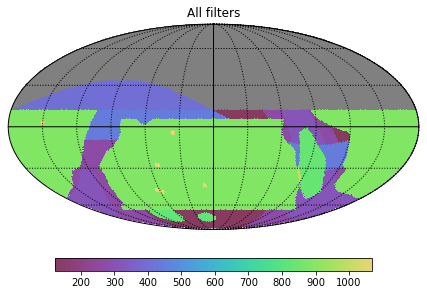

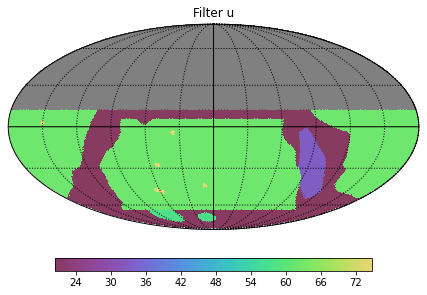

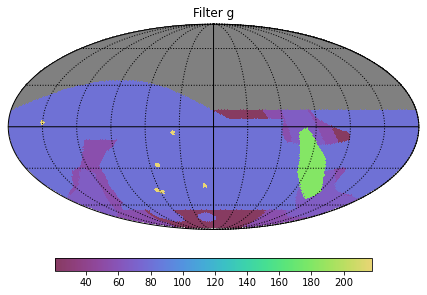

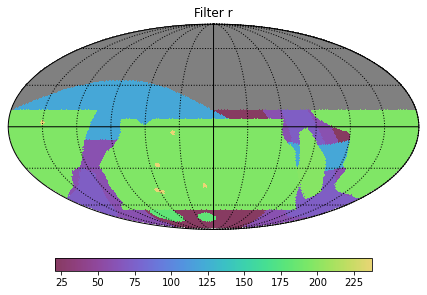

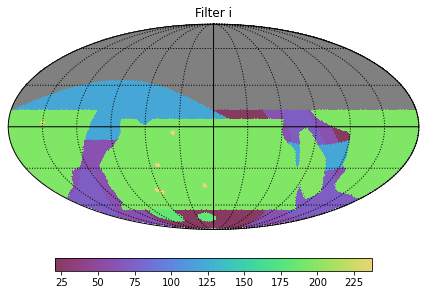

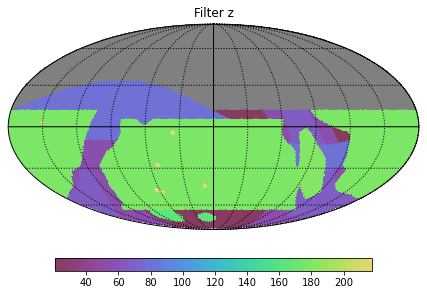

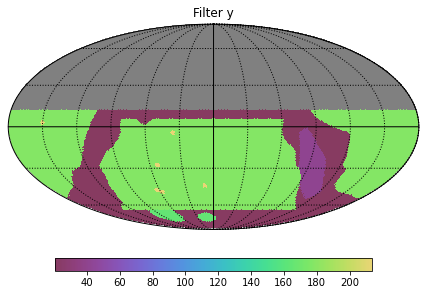

In [4]:
# Set up default sky coverage - this is used throughout below. 
# Note you can modify each part of the skymap by setting up that component separately, 
nside = 64
sky = SurveyMap()
sky.set_maps(ddf=True)
print(sky.maps.keys())
sky.combine_maps()
colorMax = np.percentile(sky.total, 98) * 1.2
sky.plot_sky(sky.total, plotDict={'title':  'All filters', 'colorMax': colorMax})
for f in sky.filterlist:
    colorMax = np.percentile(sky.total_perfilter[f], 98) * 1.2
    sky.plot_sky(sky.total_perfilter[f], plotDict={'title': f'Filter {f}', 'colorMax': colorMax})

In [5]:
calc_area_time(sky.maps['ddf'], sky.nvis['ddf'])

(58.75055516478167, 58.75055516478167, 0.05483385148712956)

In [6]:
# Quick estimates of overall survey subscription 
area, srd_area, subscription = calc_area_time(sky.total, 1)
print(f'Quick estimate of overall survey subscription {subscription}')

Quick estimate of overall survey subscription 1.0401972988600923


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


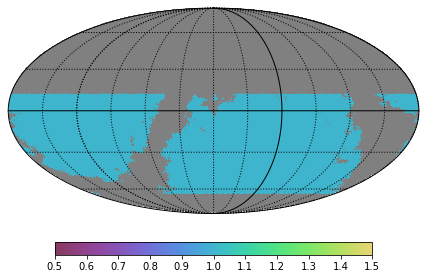

In [7]:
plotDict = {'rot': (60, 0, 0)}
sky.plot_sky(sky.dustfree, plotDict)

## Using estimates of survey time requirements ##

Text(0, 0.5, 'Survey fraction')

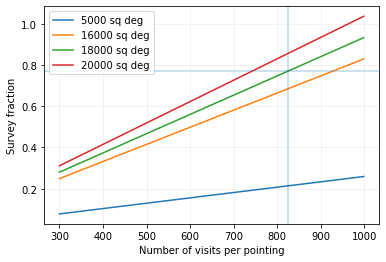

In [8]:
# which leads us to the fraction of a 2x15s 10year survey required 
# from the simulations in the notebook referenced above, I think this is accurate to an order of a % or a few,
# although smaller areas may have more 'edge effects' which would increase their required time 

nvis = np.arange(300, 1000)
for area in (5000, 16000, 18000, 20000):
    plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, area=area), label=f'{area} sq deg')
plt.axhline(0.77, alpha=0.3)
plt.axvline(825, alpha=0.3)
plt.grid(alpha=0.2)
plt.legend(loc='upper left')
plt.xlabel('Number of visits per pointing')
plt.ylabel('Survey fraction')

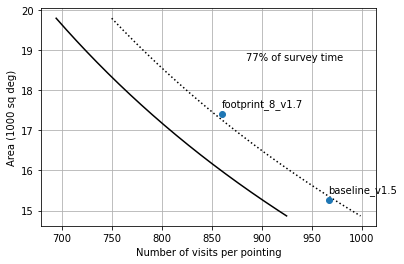

In [9]:
nvis=np.arange(750, 1000)
plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, survey_frac=0.77)/1000, 'k:')
plt.plot(nvis/1.08, scalingfunc(nvisits_per_pointing=nvis, survey_frac=0.77)/1000, 'k-')
plt.plot([860, 967], [17413/1000, 15260/1000], linestyle='', marker='o')
plt.annotate('footprint_8_v1.7', xy=[860, 17413/1000+.2])
plt.annotate('baseline_v1.5', xy=[967, 15260/1000+0.2])
plt.figtext(s='77% of survey time', x=0.6, y=0.7)
plt.xlabel('Number of visits per pointing')
plt.ylabel('Area (1000 sq deg)')
plt.grid()
# The solid line = the scaling function / 1.08 .. which both is about the level of variation between 'Minimum'
# number of visits per pointing and "Median" nvisits/pointing (in most simulations) AND a not-unreasonable amount
# of number of visits per pointing to hold as 'contingency'
# .. in other words, plan for the solid line, hope for the dashed line (?)

## Footprint per filter ## 
Due to (potentially) different filter balance being requested by GP science, and overlap between GP priority map footprint and the extragalactic WFD, we need to account for footprint requests per filter. 


## Low-dust extinction WFD

This area is the primary contributor to the SRD requirements (absolute minimum in both nvisits and area: 15000 sq deg to 750 visits). Design goals are 18,000 sq deg to 825 visits per pointing. This pushes the low-dust-extinction footprint toward bigger area; note that this may require rolling cadence implementation over this area, in order to recover SN performance (SN performance prefers more visits, preferably closer to 1000, which is the stretch goal).

There is some overlap between this area and the GP priority map footprint above, which may require visits in different filters (and those visits may even need to be at different cadences). 
Start out considering them separately and see what we can combine later.

/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


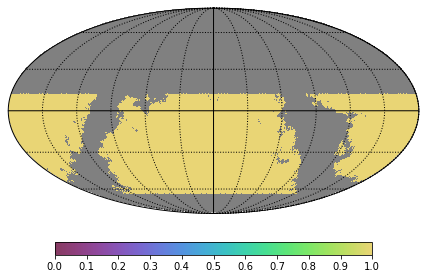

In [10]:
# Define extragalactic WFD between -72 and +12.5 with low dust extinction (dust extinction limit = 0.2)
# These dec and dust limits are used to define the other survey areas as well. 
dust_limit = 0.2
dec_max = 12.0
dec_min = -67.0

exgal_filter_balance = {'u': 0.07, 'g': 0.09, 'r': 0.22, 'i': 0.22, 'z': 0.20, 'y': 0.20}

nvis_exgal = int(825*1.08)

#sky._set_exwfd(dust_limit=dust_limit, dec_min=dec_min, dec_max=dec_max, nvis_exwfd=nvis_exgal,
#              smoothing_cutoff=0.57, smoothing_beam=10,
#              exgal_filter_balance=exgal_filter_balance, adjust_halves=True)

# Where is this (detailed dust footprint) on the sky?
plotDict = {'colorMin': 0, 'colorMax': 1}
sky.plot_sky(sky.dustfree, plotDict)

Now - we don't want to leave 'islands' unobserved within this WFD area and we want a smoother boundary at the dust extinction edges. So we've also smoothed the dust-extinction edges. 

/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


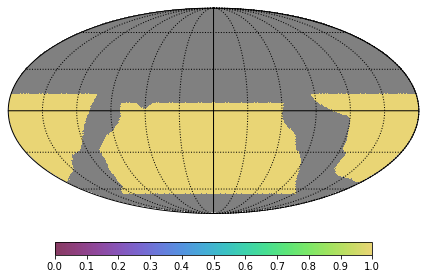

In [11]:
sky.plot_sky(sky.maps['dustfree'], plotDict)

area within dust_boundary wfd 16983.10691084796
dust-free area within dust-boundary wfd 16476.173549140414

area = 2 is added into smoothed dust boundary (too much dust, but now included),
 area = 1 is overlap (good dust and in smoothed boundary),
 and area = -1 would pass dust limit but is not included


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


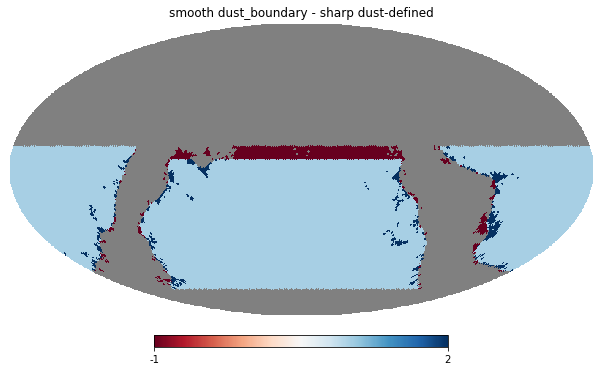

In [12]:
lowdust_area, srd_area, t_exgal = calc_area_time(sky.maps['dustfree'], nvis_exgal)
dust_free_area, j, j = calc_area_time(sky.maps['dustfree'][np.where(sky.dustmap < sky.dust_limit)], nvis_exgal)

print('area within dust_boundary wfd', lowdust_area)
print('dust-free area within dust-boundary wfd', dust_free_area)

tmp = sky.maps['dustfree'] * 2 - sky.dustfree
tmp = np.where(tmp == 0, hp.UNSEEN, tmp)
hp.mollview(tmp, title='smooth dust_boundary - sharp dust-defined', cmap='RdBu')
print('')
print('area = 2 is added into smoothed dust boundary (too much dust, but now included),\n '\
      'area = 1 is overlap (good dust and in smoothed boundary),\n '\
      'and area = -1 would pass dust limit but is not included')

0.8266067952849263

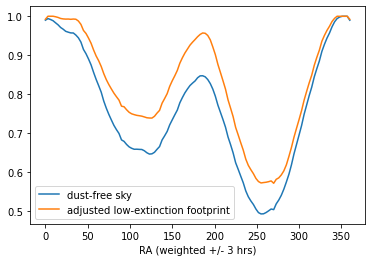

In [13]:
# It's hard to spend a lot of time on this low-dust-extinction area.
step = 3
ha_limit =  3 * 15 # step * 2
ra_area = np.arange(0, 360  + step/2, step)
area = np.zeros(len(ra_area), float)
for i, ra_cen in enumerate(ra_area):
    # consider wrap-around at RA=0, but calculate a running window's width of 'area' 
    # this is the area available within ha_limit when a given RA is overhead
    window = np.where((np.abs(sky.ra - ra_cen) < ha_limit) | (np.abs(sky.ra - ra_cen) > 360 - ha_limit), 1, 0)
    area[i] = sky.dustfree[np.where(window == 1)].sum() * hp.nside2pixarea(nside, degrees=True)
    
# Need to align 'area' and 'time'
# How?
area = area / area.max()
plt.plot(ra_area, area, label='dust-free sky')

area = np.zeros(len(ra_area), float)
for i, ra_cen in enumerate(ra_area):
    # consider wrap-around at RA=0, but calculate a running window's width of 'area' 
    # this is the area available within ha_limit when a given RA is overhead
    window = np.where((np.abs(sky.ra - ra_cen) < ha_limit) | (np.abs(sky.ra - ra_cen) > 360 - ha_limit), 1, 0)
    area[i] = sky.maps['dustfree'][np.where(window == 1)].sum() * hp.nside2pixarea(nside, degrees=True)
area = area / area.max()
plt.plot(ra_area, area, label='adjusted low-extinction footprint')

plt.legend(loc='lower left')
plt.xlabel('RA (weighted +/- 3 hrs)')

area.sum()/area.size

In [14]:
# Summary of area/time.

print(f'Area in low-extinction wfd {lowdust_area}')
print(f'Area in low-extinction wfd which is below dust-limit {dust_free_area}')

# survey time required? 
print(f"Survey fraction required for low-extinction WFD area {lowdust_area: .2f}, at {nvis_exgal} "\
      f"visits per pointing is {t_exgal: .3f}")

Area in low-extinction wfd 16983.10691084796
Area in low-extinction wfd which is below dust-limit 16476.173549140414
Survey fraction required for low-extinction WFD area  16983.11, at 891 visits per pointing is  0.785


## Galactic Plane ##

Using the "galactic plane priority map" defined by the TVS/SMWLV groups to set some information about 'ideal' coverage. However, this is also a complicated mapping so we will again use a simpler definition of area around bulge and use galactic plane priority map as weighting to evaluate priority.

In [15]:
# Note something in the TVS code doesn't seem to work appropriately at nside 128 .. use nside=64. 
gp_maps = generate_gp_maps(nside)

/Users/lynnej/other_repos/tvs_software_tools/generate_galplane_priority_maps.py:50: RuntimeWarning: divide by zero encountered in log10
  hp_log_star_density = np.log10(hp_star_density)


filter gal-balance low-dust-balance
u 0.04 0.07 0.07
g 0.22 0.09 0.09
r 0.24 0.22 0.22
i 0.24 0.22 0.22
z 0.22 0.2 0.2
y 0.05 0.2 0.2


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of 

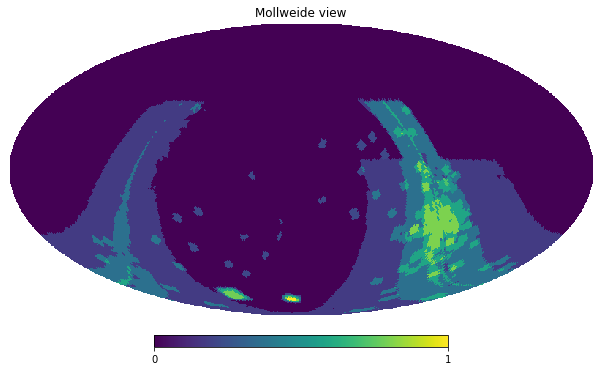

In [16]:
# gal plane priority maps are per filter - use this to get desired filter balance and to gather all-band priority map
gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    gal_total += gp_maps[f]
    #print(f, gp_maps[f].max(), gp_maps[f].min())
# Scale so the peak is 1 (to assign total number of visits across all filters later)
norm = gal_total.max()
gal_total = gal_total / norm

gal_filter_balance = {}
print('filter gal-balance low-dust-balance')
for f in sky.filterlist:
    gal_filter_balance[f] = round(gp_maps[f].max() / norm, 2)
    print(f, gal_filter_balance[f], exgal_filter_balance[f], sky.dustfree_wfd_filter_balance[f])

hp.mollview(gal_total, max=1)

There is not enough time available to observe the entire map to 825 visits per pointing, but we can do a hybrid -- take some fraction of the map and observe that to 825 visits per pointing and then observe the rest at the fraction given in the map. Use this to evaluate generally how much area we might be able to cover, for later reference. 

(I'm also going to use the fact that I already checked about number of visits per pointing in each filter and the overlap with the extragalactic area means that (assuming the cadence is ok) the visits per filter are satisfied by the extragalactic coverage - so I'll exclude that for this area calculation - see the check below. There's a similar issue with NES coverage away from the bulge, although there it's also filter-dependent).

In [17]:
nvis_gal_peak = 825
for X in np.arange(0, 1.05, 0.1):
    gal_total = np.zeros(len(gp_maps['r']), float)
    for f in gp_maps:
        gal_total += gp_maps[f]
    norm = gal_total.max()
    gal_total = gal_total / norm
    gal_total = np.where(sky.maps['dustfree'] == 1, 0, gal_total)
    # 'flatten' the map at 'X' - and set this to 825 visits per pointing. 
    # Remainder of plane will be at specified level relative to 825 (i.e. parts get 80 visits pp)
    gal_total = np.where(gal_total > X, 1, gal_total)
    eff_area, gp_srd_area, frac = calc_area_time(gal_total, nvis_gal_peak)
    print(f'{X:.2f} Effective area {eff_area:.2f} (SRD area {gp_srd_area:.2f}) Survey fraction {frac :.3f}')

0.00 Effective area 7531.82 (SRD area 7531.82) Survey fraction 0.322
0.10 Effective area 7531.82 (SRD area 7531.82) Survey fraction 0.322
0.20 Effective area 4767.52 (SRD area 4185.56) Survey fraction 0.204
0.30 Effective area 4695.26 (SRD area 4093.24) Survey fraction 0.201
0.40 Effective area 2972.69 (SRD area 1354.62) Survey fraction 0.127
0.50 Effective area 2958.84 (SRD area 1326.92) Survey fraction 0.127
0.60 Effective area 2605.53 (SRD area 471.68) Survey fraction 0.111
0.70 Effective area 2605.53 (SRD area 471.68) Survey fraction 0.111
0.80 Effective area 2596.46 (SRD area 432.24) Survey fraction 0.111
0.90 Effective area 2513.37 (SRD area 7.55) Survey fraction 0.108
1.00 Effective area 2513.37 (SRD area 7.55) Survey fraction 0.108


So we could try to use X=0.7 and see what that looks like. (we know we have an oversubscription problem, but this gives us a bit more SRD area for not a lot of time). 
BUT, this does give a pretty complicated looking footprint - which we're trying to avoid. And it also leaves parts of the plane with very little coverage. 

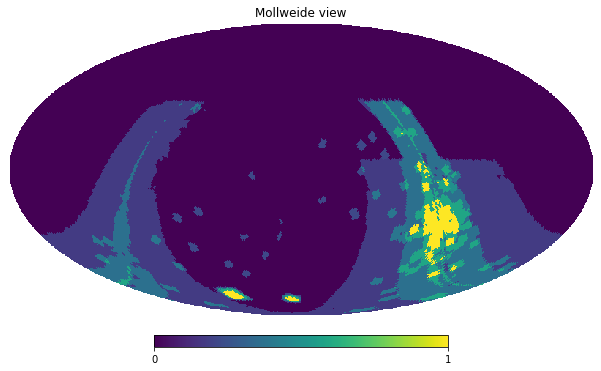

In [18]:
X = 0.7

gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    gal_total += gp_maps[f]
gal_total = gal_total / gal_total.max()
gal_total = np.where(gal_total > X, 1, gal_total)
hp.mollview(gal_total)

So now let's look at the comparison with the simpler sky map coverage.

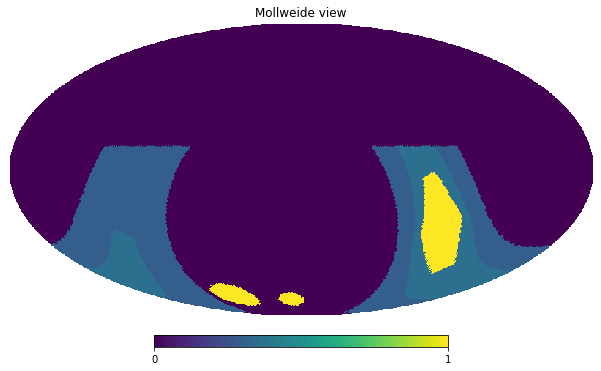

In [19]:
tmp = sky.maps['gal'] + sky.maps['mcs']
hp.mollview(tmp)


area = 0 matches coverage in priority map, area = 1 is more coverage, area = -1 is missed area


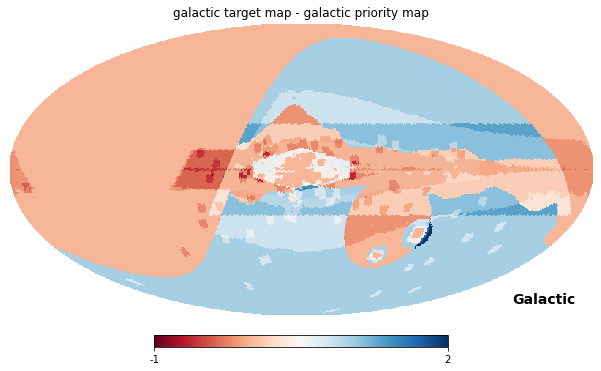

In [20]:
# Compare to priority map
t = (tmp + sky.maps['dustfree']) - gal_total
hp.mollview(t, cmap='RdBu', coord=['C', 'G'], 
            title='galactic target map - galactic priority map')
print('')
print('area = 0 matches coverage in priority map, area = 1 is more coverage, area = -1 is missed area')

In [21]:
tmp = np.where(sky.maps['dustfree']==0, tmp, 0)
gal_eff_area, gal_srd_area, t_gal = calc_area_time(tmp, sky.nvis['gal'])
print(f"effective area in galactic plane {gal_eff_area}, srd contributed area {gal_srd_area}")
print(f"fraction of survey time required {t_gal}")

effective area in galactic plane 2728.0604109069877, srd contributed area 1116.260548130852
fraction of survey time required 0.11670036202213226


## Ecliptic coverage ##

The ecliptic plane has significant overlap with over survey coverage as well. The extragalactic WFD is compatible, so will use that wherever it overlaps. The GP coverage may have different filter / time requirements, but needs more details to check. The ecliptic coverage needs to pick up some pointings around the outside edges of the plane which were not included in the galactic plane priority map -- this is worth checking with the solar system collaboration, as these visits may not be the most useful due to stellar confusion (but are in very interesting areas of the sky for exploration, as these have not generally been covered yet).

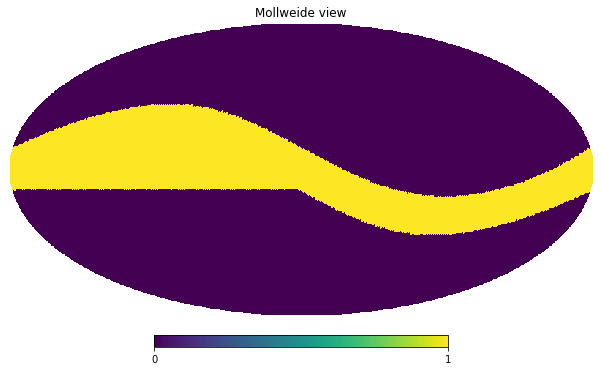

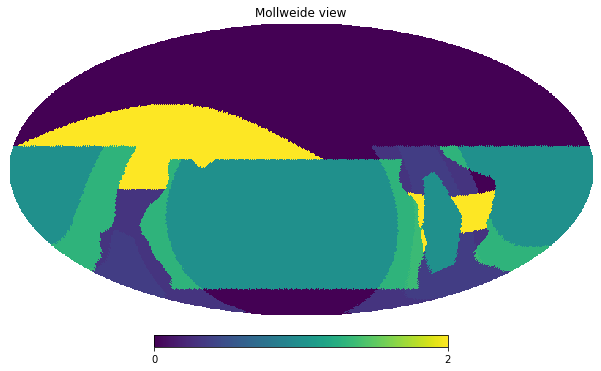

In [22]:
# Ecliptic latitude limits are not symmetric because the northern most point of the ecliptic is +23
eclat_min = -10
eclat_max = 10. 
eclip_dec_min = 0
nvis_nes = 400

hp.mollview(sky.maps['nes'], norm=None)

tmp = np.where((sky.maps['dustfree'] == 1) | (sky.maps['gal'] > .4), 0, sky.maps['nes'])
hp.mollview(tmp*2 + sky.maps['dustfree'] + sky.maps['gal'], max=2)

In [23]:
# how much area is covered? 
nes_area, j, t_nes = calc_area_time(tmp, sky.nvis['nes'])

print(f'Area in ecliptic plane total {nes_area}')
print(f"Survey fraction required for north ecliptic spur {nes_area: .2f}, at {sky.nvis['nes']} visits per pointing {t_nes:.3f}")

Area in ecliptic plane total 3954.751656235018
Survey fraction required for north ecliptic spur  3954.75, at 400 visits per pointing 0.082


## Southern Celestial Pole ##

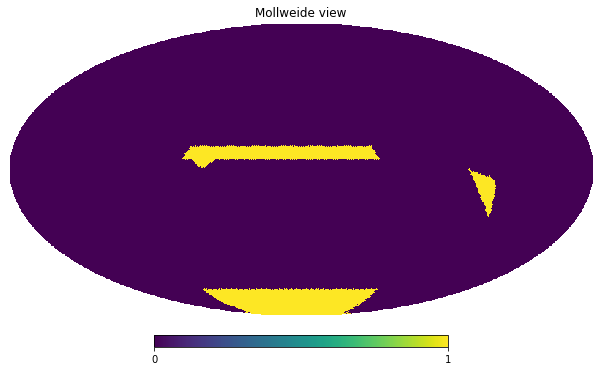

In [24]:
# Add light coverage to the southern celestial pole - the southern part of the sky that is not already covered.
tmp = np.where((sky.maps['dustfree'] == 1) | (sky.maps['gal'] > 0.2), 0, sky.maps['scp'])
hp.mollview(tmp)

In [25]:
scp_area, j, t_scp  = calc_area_time(tmp, sky.nvis['scp'])
print(f'Area in southern celestial pole {scp_area}')

print(f"Survey fraction required for south celestial pole {scp_area: .2f}, at {sky.nvis['scp']} visits per pointing {t_scp: .3f}")

Area in southern celestial pole 2083.126827414116
Survey fraction required for south celestial pole  2083.13, at 120 visits per pointing  0.013


## Total ##

In [26]:
# We need at least 5% of the time for DDFs - 1% per pointing
# The setup in the footprint above uses slightly more than 5% (?)
t_ddf = 0.05
ddf_area = t_ddf / .01 * 9.6
# We need a few percent for mini-minisurveys (ToO, twilight NEO? DCR?)
t_mini = 0.03
# But for this exercise, let's leave it at 0
t_mini = 0

There is very little survey overlap at this point (some in the NES though)

In [27]:
# Start with a basic survey footprint, just adding all of the above together.
surveyfootprint, survey_maps = sky.total, sky.total_perfilter

In [28]:
# We do need to check that we're planning for about 18k sq deg to be visited to at least 825 per SRD
nvis_min_srd = 750
goal_srd = len(np.where(surveyfootprint >= nvis_min_srd)[0]) * hp.nside2pixarea(nside, degrees=True)
res_srd = len(np.where(surveyfootprint >= 825)[0]) * hp.nside2pixarea(nside, degrees=True)
print(f"Area covered to at least {nvis_min_srd} visits per pointing {goal_srd}")
print(f"Area covered to at least {825} visits per pointing {res_srd}")

Area covered to at least 750 visits per pointing 18099.367458978813
Area covered to at least 825 visits per pointing 18099.367458978813


In [31]:
t_total = t_exgal + t_gal + t_nes + t_scp
t_total += t_ddf + t_mini
# effective total area (because we're discounting parts of the GP which are not covered at full depth ..)
area_total = lowdust_area + gal_eff_area + nes_area  + scp_area + ddf_area

pd.DataFrame([[lowdust_area, t_exgal, sky.nvis['dustfree']], 
              [gal_eff_area, t_gal, sky.nvis['gal']],
              [nes_area, t_nes, sky.nvis['nes']], 
              [scp_area, t_scp, sky.nvis['scp']], 
              [ddf_area, t_ddf, np.nan], 
              [np.nan, t_mini, np.nan],
              [area_total, t_total, np.nan]], 
             columns=["Area (sq deg)", "Survey Fraction", "Nvis/pointing"], 
             index=["Extragalactic", "GP map", "NES",  "SCP", "DDF", "Mini", "Total"]

,Area (sq deg),Survey Fraction,Nvis/pointing
Extragalactic,16983.106911,0.784620,891.0
GP map,2728.060411,0.116700,825.0
NES,3954.751656,0.082024,400.0
SCP,2083.126827,0.012962,120.0
DDF,48.000000,0.050000,NaN
Mini,NaN,0.000000,NaN
Total,25797.045805,1.046306,NaN


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


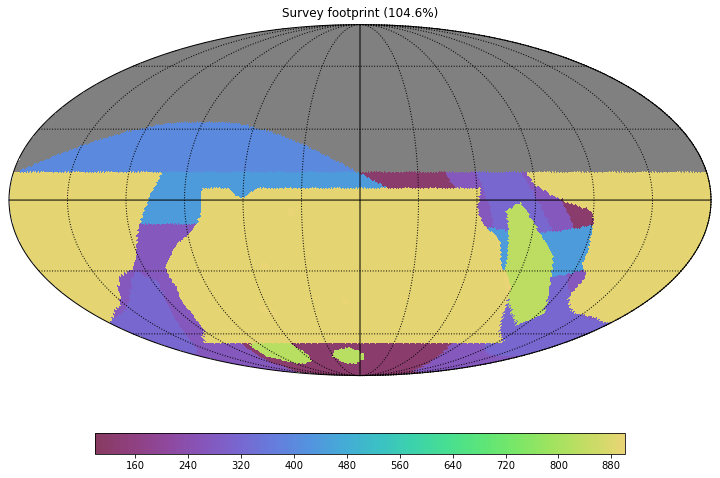

In [35]:
plotDict = {'title': f'Survey footprint ({t_total*100:.1f}%)', 
            'colorMax': 900, 'colorMin':100, 'figsize': (10, 8)}
sky.plot_sky(surveyfootprint, plotDict)

/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/lynnej

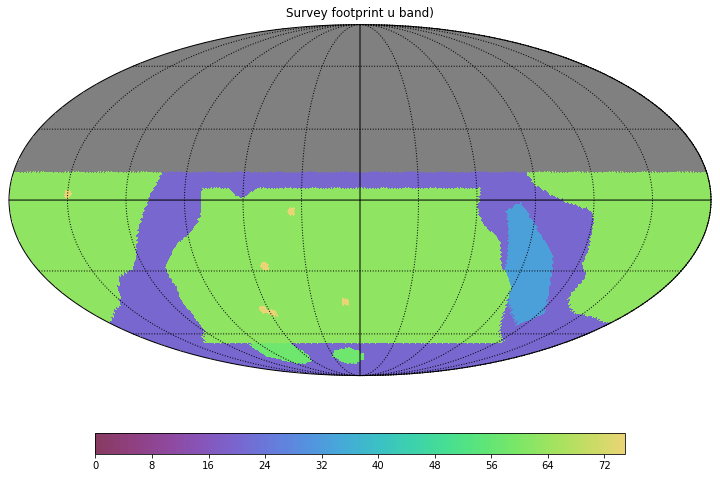

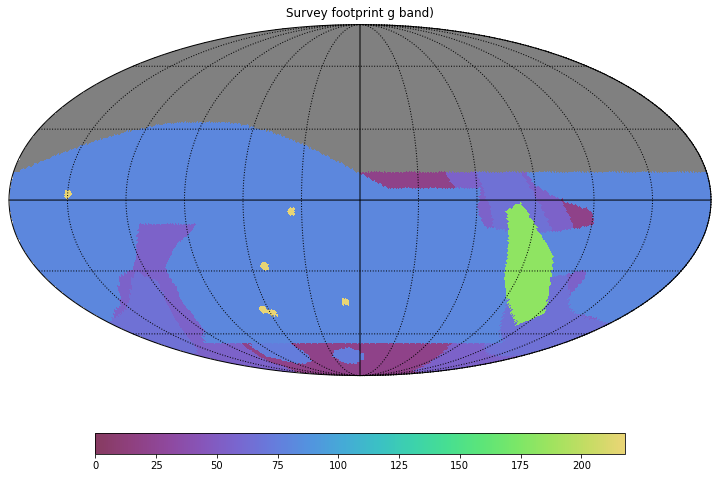

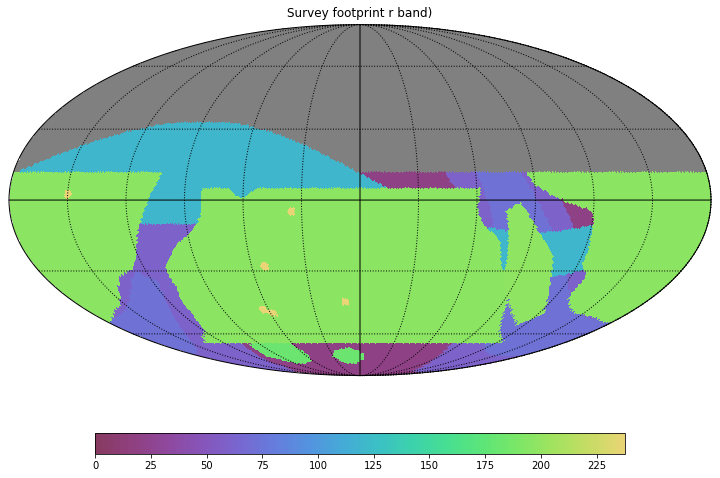

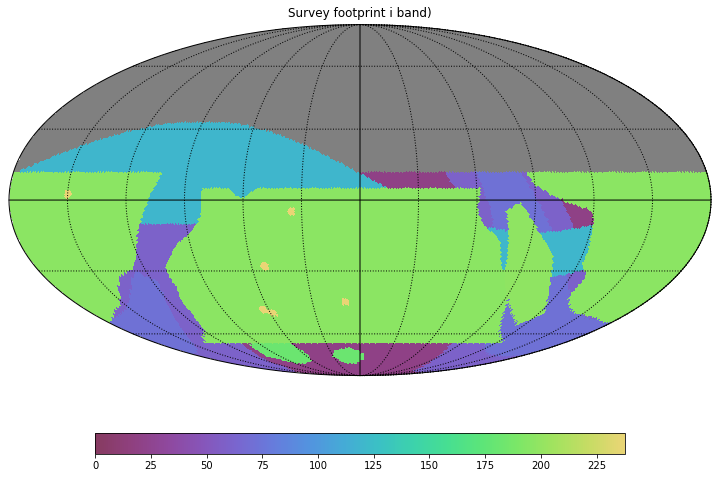

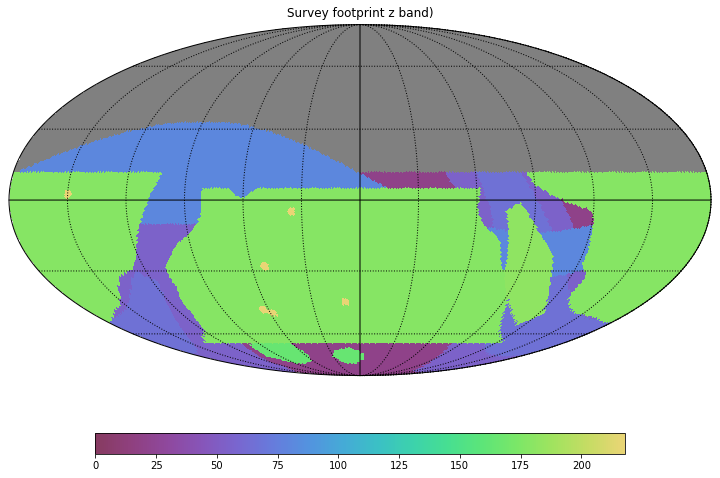

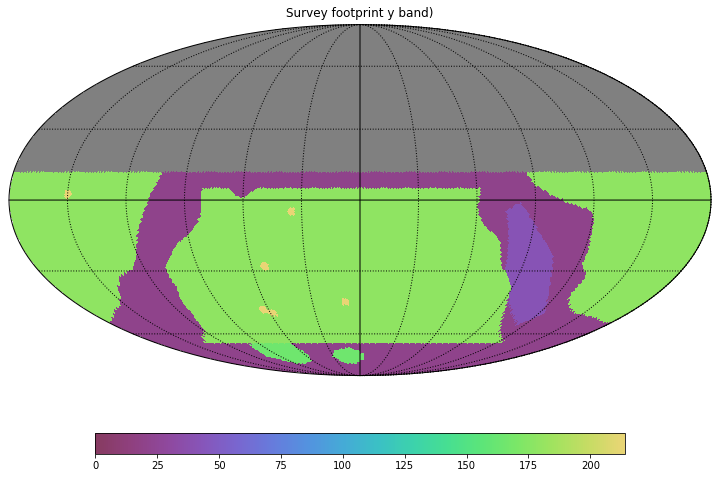

In [36]:
for f in sky.filterlist:
    plotDict = {'title': f'Survey footprint {f} band)', 'figsize': (10, 8),
               'colorMin': 0, 'colorMax': np.percentile(survey_maps[f], 98) * 1.2}
    sky.plot_sky(survey_maps[f], plotDict)

Some thoughts on this: it's pretty close to what we need . but there are lots of places I could have gotten this wrong or that these approximations don't map well against reality. Some places I could imagine a real simulation needing more time than approximated:

 * I've made an approximation of the effective area and then scaled by the median number of visits - both of these may be neglecting 'tails' in the distribution. Hopefully this is not a large effect, but this treatment could be wrong, and it could be fairly far wrong in the worst case.
 * there are plenty of 'edges' in the footprints -- the edge of the dust extinction limits for the extragalactic footprint and the many, many small areas in the galactic plane priority maps may be problematic. If a field of view doesn't map well onto these edges we will need more visits to cover the edge to the level that is desired. 
 * The footprint has been treated in an 'average' manner, without considering the effects of over or under subscription in various RA zones. This can push the number of visits that are possible in some parts of the sky below what is approximated here. 
 * The distribution of visits has been treated as though cadence doesn't matter; this is almost certainly not true for most of these points in the sky, but is hopefully close enough that it is not a large effect (as long as the cadence for the extragalactic pointings is consistent with what is needed in the wings of the galactic plane, this seems likely to be 'close enough'). 
 
However, most of the questions above seem reasonable to try to address with a simulation and see how bad the assumptions are. We'll give it a go, if it seems useful.

## Time available at each RA range ##

One of the big problems we find when we look at this in a simulation is that some areas of the sky are oversubscribed while others are undersubscribed.  We can try to estimate this by looking at the survey area as a function of RA (as a function of visibility would be better, but RA + HA seems likely to get pretty close). 
And then also to look at time available throughout the year and likely impact of weather and scheduled shutdowns. 

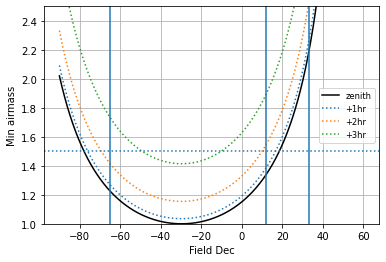

In [37]:
# Want to weight footprint 
tele_lat = -29.666667

dec_min = np.max([tele_lat-90, -90])
dec_max = np.min([tele_lat+90, 90])
field_dec = np.arange(dec_min, dec_max, 0.25)

min_z = np.radians(np.abs(field_dec - tele_lat))
min_airmass = 1 / np.cos(min_z)

plt.plot(field_dec, min_airmass, 'k-', label='zenith')

# Add expected airmass for +/- X hours around meridian
# cos z  =cos(min_z) * cos(ha_offset)
for x in [1, 2, 3]:
    ha_offset = np.radians(x * 15)
    plus_x = np.arccos(np.cos(min_z) * np.cos(ha_offset))
    airmass_x = 1. / np.cos(plus_x)
    plt.plot(field_dec, airmass_x, linestyle=':', label=f'+{x}hr')

plt.legend(loc='right', fancybox=True, fontsize='small')
plt.xlabel('Field Dec')
plt.ylabel('Min airmass')
plt.axvline(sky.dec_min)
plt.axvline(sky.dec_max)
plt.axvline(23+sky.eclat_max)
plt.axhline(1.5, linestyle=':')
plt.ylim(1, 2.5)
plt.grid(True)

6300049.311038663 5014887.561309572


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


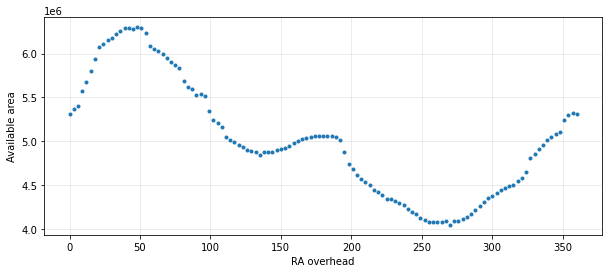

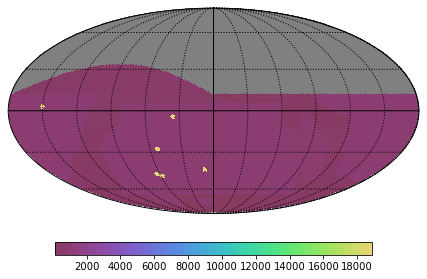

In [38]:
# So don't really want to push visits beyond +/- 2 (max 3?) HA (HA = LST - RA) 
ha_limit = 3 * 15
step = 3
ra = np.arange(0, 360  + step/2, step)
area = np.zeros(len(ra), float)
for i, ra_cen in enumerate(ra):
    # consider wrap-around at RA=0, but calculate a running window's width of 'area' 
    # this is the area available within ha_limit when a given RA is overhead
    window = np.where((np.abs(sky.ra - ra_cen) < ha_limit) | (np.abs(sky.ra - ra_cen) > 360 - ha_limit), 1, 0)
    area[i] = sky.total[np.where(window == 1)].sum() * hp.nside2pixarea(nside, degrees=True)

plt.figure(figsize=(10, 4))
plt.plot(ra, area, linestyle='', marker='.')
plt.grid(True, alpha=0.3)
plt.ylabel('Available area')
plt.xlabel('RA overhead')
print(area.max(), area.mean())
sky.plot_sky(sky.total)

In [39]:
import rubin_sim.site_models as rs_site
from datetime import datetime
import pytz
from astropy.time import Time
from astropy.coordinates import EarthLocation

In [40]:
# Set up local midnight (and account for timezone)
tz = 'Chile/Continental'
timezone = pytz.timezone(tz)
time = datetime(year=2023, month=12, day=21, hour=0, minute=0, second=0, tzinfo=timezone)

lsst_loc = EarthLocation.of_site('Cerro Pachon')
mjd_midnight = Time(time, location=lsst_loc)
lst_midnight = mjd_midnight.sidereal_time('apparent')

print(mjd_midnight.isot, mjd_midnight.utc.mjd, lst_midnight.deg)

2023-12-21T04:43:00.000 60299.19652777778 89.51561322974497


In [41]:
mjd_start = mjd_midnight - 0.5
print(mjd_start)

2023-12-20 16:43:00


In [42]:
dt = rs_site.ScheduledDowntimeData(mjd_start)
dt.read_data()

mod_downtimes = [((t[0].mjd - mjd_start.mjd) % 365.25, (t[1].mjd - mjd_start.mjd) % 365.25) for t in dt()]
mod_downtimes[0:10]

[(169.2134722222254, 176.2134722222254),
 (318.2134722222254, 325.2134722222254),
 (168.9634722222254, 175.9634722222254),
 (317.9634722222254, 324.9634722222254),
 (168.7134722222254, 182.7134722222254),
 (168.4634722222254, 175.4634722222254),
 (317.4634722222254, 324.4634722222254),
 (168.2134722222254, 182.2134722222254),
 (167.9634722222254, 174.9634722222254),
 (316.9634722222254, 323.9634722222254)]

In [43]:
cloud_limit=0.3

almanac = rs_site.Almanac(mjd_start=mjd_start.mjd)
cloud_data = rs_site.CloudData(mjd_start, offset_year=0)

In [44]:
nyrs = 10
spacing = 1/24/10.0
print(f'{nyrs} yrs at {spacing} days ({spacing*60} hours)')
mjds = np.arange(mjd_start.utc.mjd, mjd_start.utc.mjd+365.25*nyrs, 1/24/10.)
times = Time(mjds, format='mjd', scale='utc', location=lsst_loc)
# These are UTC times, but the location means we get the RA which is overhead
lst = times.sidereal_time('mean').deg

10 yrs at 0.004166666666666667 days (0.25 hours)


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 611087 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 611087 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [45]:
# This is slow ...
bulk_cloud = [cloud_data(time) for time in times]
sun_moon_info = almanac.get_sun_moon_positions(mjds)

/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [46]:
# Check the almanac covers our timespan
almanac.sunsets['sunset'].min(), almanac.sunsets['sunrise'].max(), mjds.min(), mjds.max()

(58757.94473026553, 67889.43350666994, 60298.69652777778, 63951.1923602607)

In [47]:
good = np.where((sun_moon_info['sun_alt'] < np.radians(-12.)) & (np.array(bulk_cloud) < cloud_limit))[0]
sun_down = np.where((sun_moon_info['sun_alt'] < np.radians(-12)))[0]

# This identifies which almanac entries are relevant for these mjds
almanac_indx = almanac.mjd_indx(mjds)
# And this identifies which 'nights' correspond to these entries
nights = almanac.sunsets['night'][almanac_indx]

(2.0, 12.0)

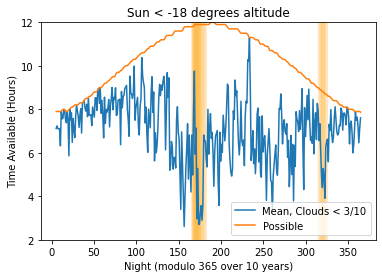

In [48]:
# How much time do we have available at different days in the year?
times = np.ones(np.size(good))*(mjds[1]-mjds[0])*24
all_times = np.ones(np.size(sun_down))*(mjds[1]-mjds[0])*24

n = nights[good] % 365
# fudge the bins because there's something weird going on at the start I don't want to bother wth
bins = np.arange(5., 366, 1)
hours_available, be, bi = scipy.stats.binned_statistic(n, times, bins=bins, statistic=np.sum)

all_hours_possible, be, bi = scipy.stats.binned_statistic((nights[sun_down] % 365), all_times,
                                              bins=bins, statistic=np.sum)

night_binned = (be[1:]+be[:-1])/2
plt.plot(night_binned, hours_available/nyrs, label='Mean, Clouds < 3/10')
plt.plot(night_binned, all_hours_possible/nyrs, label='Possible')
plt.xlabel(f'Night (modulo 365 over {nyrs} years)')
plt.ylabel('Time Available (Hours)')
plt.title('Sun < -18 degrees altitude')
plt.legend()

for dt in mod_downtimes:
    plt.fill_between(dt, [0,0], y2=[15,15], alpha=.05, color='orange')
plt.ylim([2,12])

shortest night available at LST (due to sun) = [90.00015019]
corresponding to winter solstice 2024-12-21T04:43:00.000 60665.19652777778 90.26405561762319
shortest night available at LST (due to sun + weather) = [295.19925051]
corresponding to late summer 2024-07-18T04:43:00.000 60509.19652777778 296.50259999496234


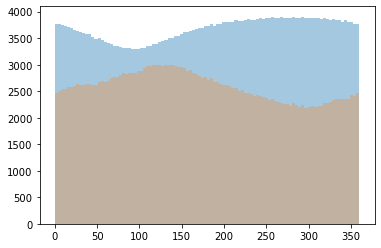

In [49]:
#n,b,p = plt.hist(lst, bins=100, alpha=0.4)
n,b,p = plt.hist((lst[sun_down]), # - lst[0]) % 360, 
                  bins=100, alpha=0.4)
n,b,p = plt.hist((lst[good]), # - lst[0]) % 360, 
                 bins=100, alpha=0.3)
n,b = np.histogram(lst[sun_down], bins=100)
print(f'shortest night available at LST (due to sun) = {b[np.where(n == n.min())]}')

tz = 'Chile/Continental'
timezone = pytz.timezone(tz)
time = datetime(year=2024, month=12, day=21, hour=0, minute=0, second=0, tzinfo=timezone)

lsst_loc = EarthLocation.of_site('Cerro Pachon')
mjd_midnight = Time(time, location=lsst_loc)
lst_midnight = mjd_midnight.sidereal_time('apparent')

print('corresponding to winter solstice', mjd_midnight.isot, mjd_midnight.utc.mjd, lst_midnight.deg)

n,b = np.histogram(lst[good], bins=100)
print(f'shortest night available at LST (due to sun + weather) = {b[np.where(n == n.min())]}')

tz = 'Chile/Continental'
timezone = pytz.timezone(tz)
time = datetime(year=2024, month=7, day=18, hour=0, minute=0, second=0, tzinfo=timezone)

lsst_loc = EarthLocation.of_site('Cerro Pachon')
mjd_midnight = Time(time, location=lsst_loc)
lst_midnight = mjd_midnight.sidereal_time('apparent')

print('corresponding to late summer', mjd_midnight.isot, mjd_midnight.utc.mjd, lst_midnight.deg)

Text(0.5, 0, 'RA')

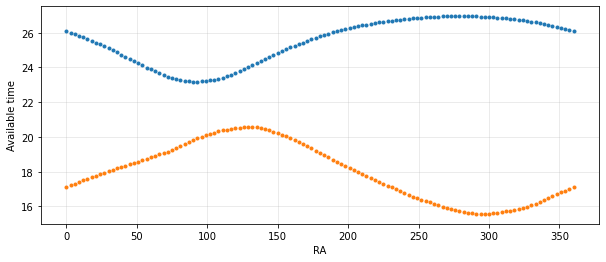

In [50]:
# Estimate the amount of time we could spend at any given RA value, assuming could observe up to HA=2.
ha_limit = 2 * 15
step = 3
ra = np.arange(0, 360  + step/2, step)
time_ra_sun = np.zeros(len(ra), float)
time_ra_good = np.zeros(len(ra), float)
for i, ra_cen in enumerate(ra):
    # consider wrap-around at RA=0, but calculate a running window's width of 'area' 
    # this is the area available within ha_limit when a given RA is overhead
    window = np.where((np.abs(lst[sun_down] - ra_cen) < ha_limit) | 
                      (np.abs(lst[sun_down] - ra_cen) > (360 - ha_limit)), 1, 0)
    time_ra_sun[i] = len(lst[np.where(window == 1)]) * (spacing / nyrs )
    window = np.where((np.abs(lst[good] - ra_cen) < ha_limit) | 
                      (np.abs(lst[good] - ra_cen) > (360 - ha_limit)), 1, 0)
    time_ra_good[i] = len(lst[np.where(window == 1)]) * (spacing / nyrs )

plt.figure(figsize=(10, 4))
plt.plot(ra, time_ra_sun, linestyle='', marker='.')
plt.plot(ra, time_ra_good, linestyle='', marker='.')
plt.grid(True, alpha=0.3)
plt.ylabel('Available time')
plt.xlabel('RA')

In [51]:
# Go back to footprint and remove 'window' because we're accounting for it above 
# Or include window still, because even though it's included above, it makes it easier to evaluate the plot?
step = 3
ha_limit =  2 * 15 # step * 2
ra_area = np.arange(0, 360  + step/2, step)
area = np.zeros(len(ra_area), float)
for i, ra_cen in enumerate(ra_area):
    # consider wrap-around at RA=0, but calculate a running window's width of 'area' 
    # this is the area available within ha_limit when a given RA is overhead
    window = np.where((np.abs(sky.ra - ra_cen) < ha_limit) | (np.abs(sky.ra - ra_cen) > 360 - ha_limit), 1, 0)
    area[i] = sky.total[np.where(window == 1)].sum() * hp.nside2pixarea(nside, degrees=True)
    
# Need to align 'area' and 'time'
# How?
area = area / area.max() * 25

25.0 18.72571027045632


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


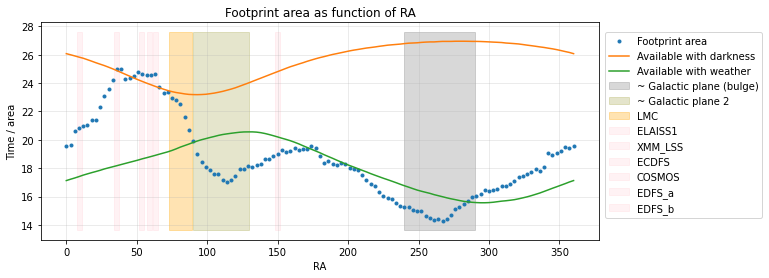

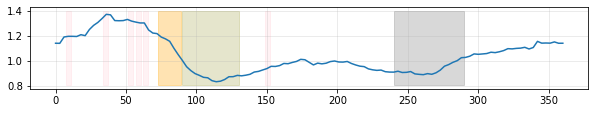

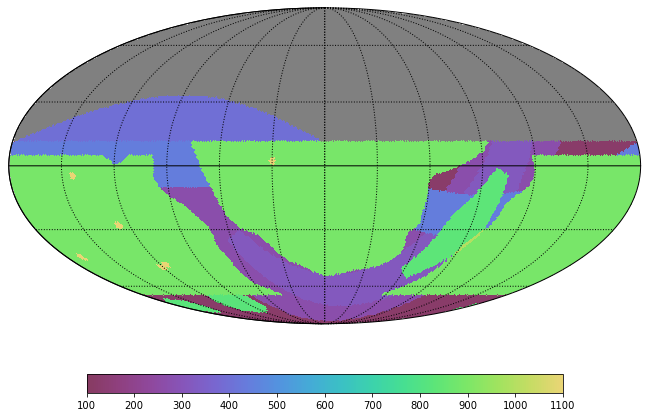

In [60]:
def highlight_areas():
    y1, y2 = plt.ylim()
    plt.fill_between([240, 290], y1=y1, y2=y2, color='gray', alpha=0.3, label='~ Galactic plane (bulge)')
    plt.fill_between([90, 130], y1=y1, y2=y2, color='olive', alpha=0.2, label='~ Galactic plane 2')
    plt.fill_between([(sky.lmc_ra - sky.lmc_radius), (sky.lmc_ra + sky.lmc_radius)], 
                     y1=y1, y2=y2, color='orange', alpha=0.3, label='LMC')
    for dd in sky.ddf_centers:
        plt.fill_between([sky.ddf_centers[dd][0] - sky.ddf_radius, sky.ddf_centers[dd][0] + sky.ddf_radius],
                         y1=y1, y2=y2, color='pink', alpha=0.2, label=f'{dd}')
    return


plt.figure(figsize=(10, 4))
plt.title('Footprint area as function of RA')
plt.plot(ra_area, area, linestyle='', marker='.', label='Footprint area')
plt.plot(ra, time_ra_sun, linestyle='-', label='Available with darkness')
plt.plot(ra, time_ra_good, linestyle='-', label='Available with weather')
plt.grid(True, alpha=0.3)
plt.ylabel('Time / area')
plt.xlabel('RA')
highlight_areas()
plt.legend(loc=(1.01, 0.1), fancybox=True)
print(area.max(), area.mean())

plt.figure(figsize=(10, 1.5))
plt.plot(ra, (area / time_ra_good))
highlight_areas()
plt.grid(True, alpha=0.3)
plotDict={'colorMin': 100, 'colorMax': 1100, 'figsize': (9, 7),
         'rot': (180, 0, 0), 'flip': 'geo'}
sky.plot_sky(sky.total, plotDict)